#  Прогнозирование заказов такси

# Содержание

- [Введение](#intro)
- [Подготовка](#preparation)
- [Анализ](#analysis)
  - [Выводы по анализу](#analysis_conclusion)
- [Обучение](#fit)
  - [Линейная регрессия](#lr)
  - [Древо Решений](#dt)
  - [Catboost](#catboost)
  - [Выводы по обучению](#fit_conclusion)
- [Тестирование](#test)
  - [Проверка на адекватность](#adequacy_check)
- [Выводы](#conclusion)

<a id='intro'></a>
## Введение
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Нам предоставлены данные о заказах такси в аэропортах. Используя эти данные нужно сделать прогноз количества заказов такси на следующий час. По условию мы должны руководствоваться метрикой RMSE и удовлетворительным результат будет считататься при значении меньше 48. Такую метрику мы должны получить на тестовой выборке (по условию - 10% от исходных данных). Данные предоставлены в виде одного csv файла, изучим его, сделаем анализ. После этого подготовим данные для работы с моделями машинного обучения и проверим как различные модели покажут себя на тренировочных данных, после этого остановимся на лучшей и проверим её на тестовой выборке.

<a id='preparation'></a>
## Подготовка

**Импортируем необходимые библиотеки**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit

from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostRegressor

**Читаем файл с предоставленными данными**

In [2]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates=[0], index_col=['datetime'])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, parse_dates=[0], index_col=['datetime'])
else:
    print('Something is wrong')

**Основная информация о датафрейме**

Посмотрим на данные.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Имеем данные за период с 1 марта 2018 года до 31 августа 2018 года. Видим что каждой строке соответсвует колличество заказов за 10 минут.

Проверим в хронологическом порядке расположены индексы или нет. При необходимости сделаем сортировку.

In [5]:
print(data.index.is_monotonic)

True


Индексы расположены в хронологическом порядке, сортировка не требуется.

Нас интересуют данные за час. Произведём ресемплирование данных по часу.

In [6]:
data = data.resample('1H').sum()

In [7]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Ресемплирование выполнили, теперь в каждой строке находятся колличество заказов за час.

<a id='analysis'></a>
## Анализ

Посмотрим на график количества заказов за весь период.

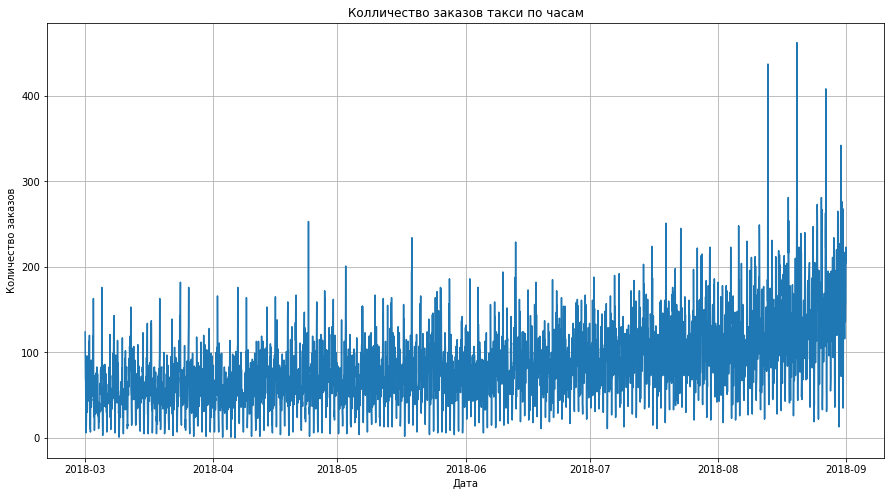

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(data)
plt.title("Колличество заказов такси по часам")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.show()

На графике наблюдаем в августе рост к концу месяца, за остальной период однозначного раста не видно, возможно есть небольшой. Построим график со скользящим средним. Рамку зададим = 24 (сутки в данном случае).

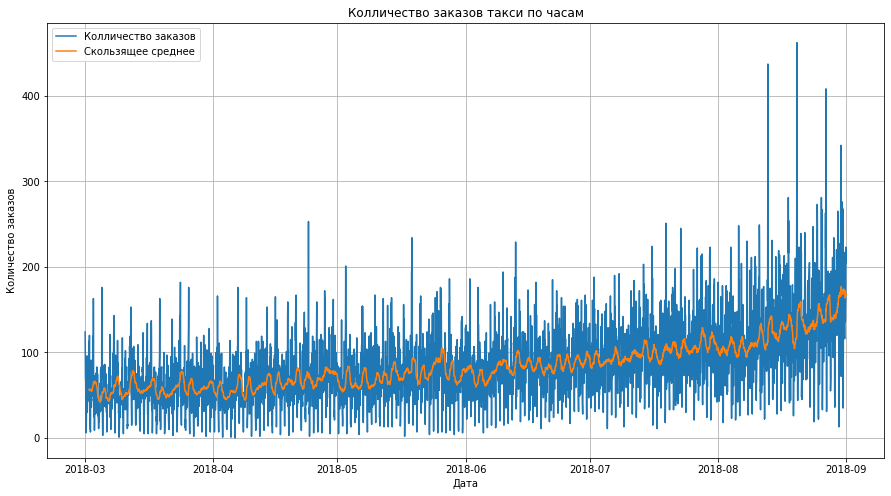

In [9]:
data['rolling_mean'] = data.shift().rolling(24).mean()

plt.figure(figsize=(15, 8))
plt.plot(data['num_orders'], label='Колличество заказов')
plt.plot(data['rolling_mean'], label='Скользящее среднее')
plt.title("Колличество заказов такси по часам")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

data = data.drop(['rolling_mean'], axis=1)

Теперь рост более явно виден. До июня рост совсем небольшой, после этого более заметный.

Разберём тренд и сезонность, данные ограничим за период начиная с июня.

In [10]:
decomposed = seasonal_decompose(data['2018-06-01':'2018-08-31'])

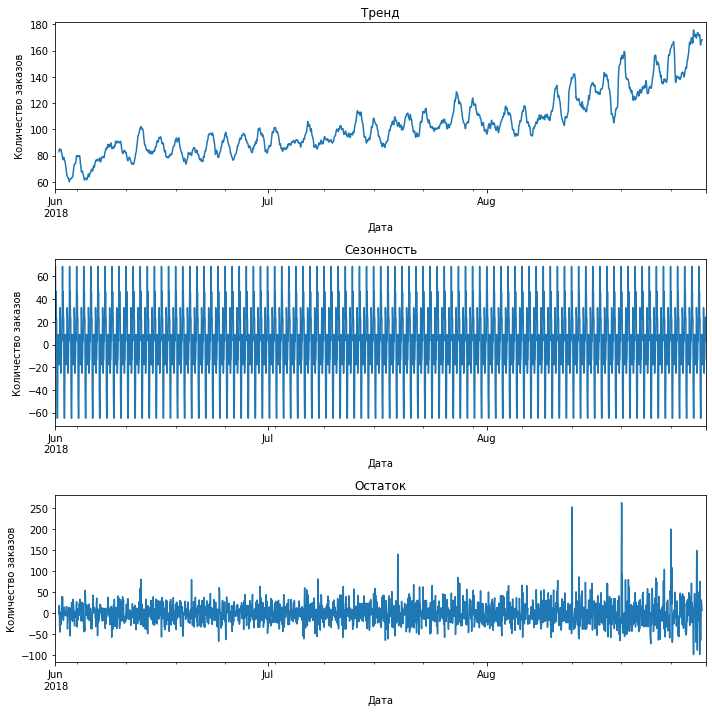

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel("Количество заказов")
plt.xlabel("Дата")
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.ylabel("Количество заказов")
plt.xlabel("Дата")
plt.tight_layout()

По тренду видим увеличение заказов с пиком в конце августа. Сезонность за данный отрезок тяжело проанализировать, нужно выбрать меньший отрезок и проанализировать его. В остатках видим по второй половине августа увеличенные значения, в остальной пероид наблюдаем стабильность.

Посмотрим на сезонность за первую неделю августа.

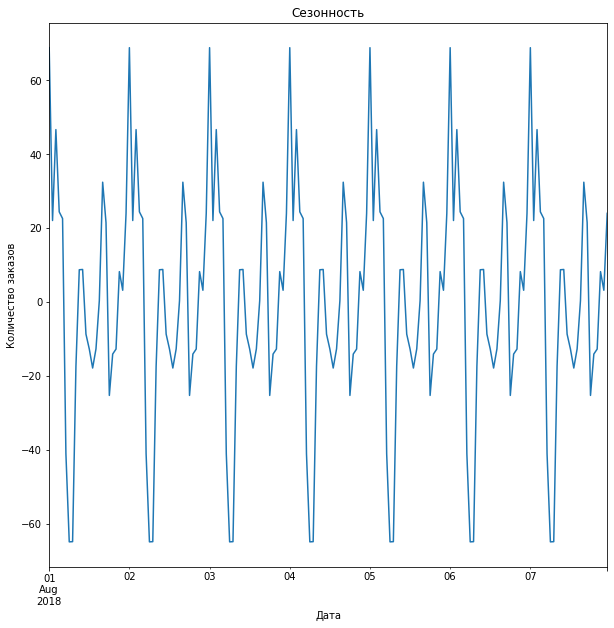

In [12]:
plt.figure(figsize=(10, 10))
decomposed.seasonal['2018-08-01':'2018-08-7'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Дата")
plt.ylabel("Количество заказов");

Видим явное присутвие сезонности в данных. Каждый день идёт спад заказов ночью. после 00:00 и в течении дня более менее стабильное значение с увеличением к концу дня.

Посмотрим сезонность за один день.

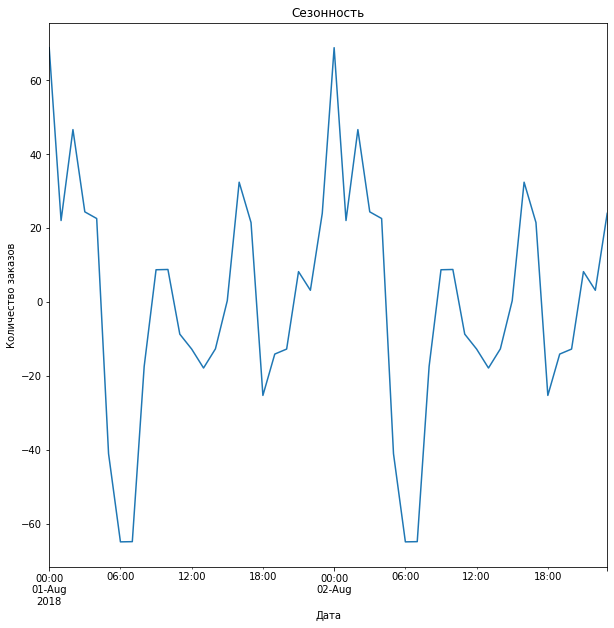

In [13]:
plt.figure(figsize=(10, 10))
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Дата")
plt.ylabel("Количество заказов");

Предыдущие выводы подтверждаются. Видим пик заказов в 00:00, увеличение к этому времени начинается с 18:00. Другой, меньший пик около 15:00. Максимальный спад находится в 06:00.

Можем предположить что в 00:00 другой вид траспорта не ходит из аэропорта. А по остальным пикам, они могут быть связаны с временем рейсов, возможно около 7, 15 и ближе к полуночи увеличенное количество вылетов-прилётов по сравнению с другим временем.

Можем сделать вывод что присутсвует сезонность выраженная в увеличинной нагрузке в позднее вечернее время и минимальной в раннее утреннее.

Посмотрим на тренд за август.

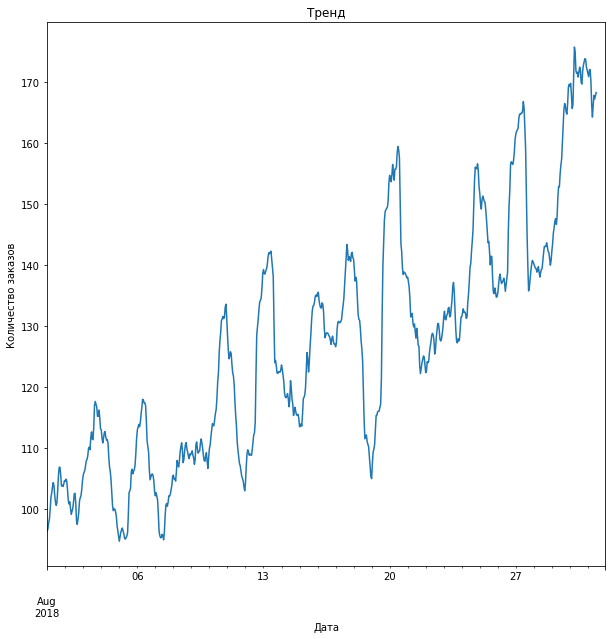

In [14]:
plt.figure(figsize=(10, 10))
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Дата")
plt.ylabel("Количество заказов");

По тренду видим рост в течении всего месяца, а так же наблюдаем следующую закономерность: на воскресенья приходятся резкие спады, а на понедельник резкие подъёмы (дни сопоставили с календарём за 2018 год чтобы определить дни недели, например 5 августа - воскресенье в 2018 году).

Посмотрим на скользящее среднее отклонение.

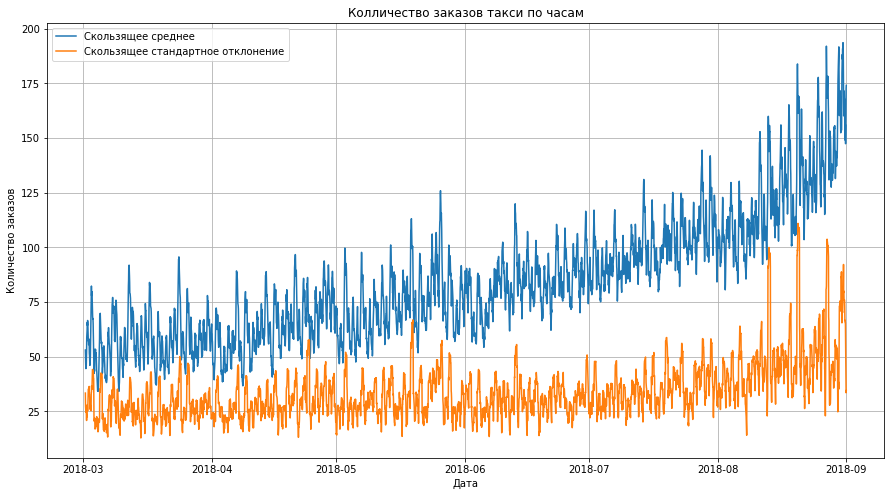

In [15]:
mean_std = data.copy()
mean_std['mean'] = data['num_orders'].rolling(15).mean()
mean_std['std'] = data['num_orders'].rolling(15).std()

plt.figure(figsize=(15, 8))
plt.plot(mean_std['mean'], label='Скользящее среднее')
plt.plot(mean_std['std'], label='Скользящее стандартное отклонение')
plt.title("Колличество заказов такси по часам")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

mean_std = mean_std.drop(['num_orders'], axis=1)

Можем сделать вывод что временной ряд нестационарный.

Дополнительно проверим с помощью теста Дики-Фуллера временной ряд на стационарность.

In [16]:
result = adfuller(data['num_orders'])

print('Критерий ADF:', result[0])
print('P-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'{key}: {value}')

Критерий ADF: -3.0689242890279558
P-значение: 0.028940051402612906
Критические значения:
1%: -3.431842162413052
5%: -2.8621993540813637
10%: -2.567120978470452


In [17]:
alpha = 0.01
print('Уровень значимость 1%')

if result[1] <= alpha:
    print("Отклоняем нулевую гипотезу: Ряд стационарен")
else:
    print("Не отклоняем нулевую гипотезу: Ряд нестационарен")

Уровень значимость 1%
Не отклоняем нулевую гипотезу: Ряд нестационарен


In [18]:
alpha = 0.05
print('Уровень значимость 5%')


if result[1] <= alpha:
    print("Отклоняем нулевую гипотезу: Ряд стационарен")
else:
    print("Не отклоняем нулевую гипотезу: Ряд нестационарен")

Уровень значимость 5%
Отклоняем нулевую гипотезу: Ряд стационарен


При уровне значимости 1% нулевая гипотеза подтверждается, ряд нестационарный.

<a id='analysis_conclusion'></a>
### Выводы по анализу

Изучили имеющиеся данные.

- Выявили что присутсвует тренд на увеличение заказов который более явно начинает прослеживатся начиная с июня. Так же определили наиболее загруженный и разгруженный дни недели - Понедельник и Воскресенье соответсвенно.
- Проверили наличие сезонности. Присутсвует сезонность, ближе к 00:00 максимальная загруженность и около 06:00 минимальная.
- Проверили временной ряд на стационарность, ряд нестационарный, среднее отклонение и среднее значение меняется в ряду.

<a id='fit'></a>
## Обучение

Для начала нам нужно создать признаки для модели. Создадим календарные признаки, отстающие значения и скользящее среднее.

In [19]:
def make_features(data, max_lag, rolling_mean_size):

    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Создали функцию для создания следующих признаков: день, день недели, час, отстающие значения и скользящие среднее.

In [20]:
ml_data = data.copy()

In [21]:
make_features(ml_data, 11, 30)

Признаки создали, разобьём данные на выборки, тренировочная и тестовая в соотношении 90%/10% соответсвенно.

In [22]:
RANDOM_STATE = 12345

In [23]:
train, test = train_test_split(ml_data, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()

In [24]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [25]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3944, 15)
(442, 15)
(3944,)
(442,)


Разбитие провели, размеры проверили, всё корректно.

<a id='lr'></a>
### Линейная регрессия

Обучим линейную регрессию с помощью кросс-валидации GridSearchCV и посмотрим на RMSE.

In [26]:
%%time
tss = TimeSeriesSplit(n_splits = 3)

params = {}

lr_model = LinearRegression()

lr_model_cv = GridSearchCV(estimator = lr_model, 
                           param_grid = params, 
                           scoring= 'neg_root_mean_squared_error', 
                           cv = tss, 
                           verbose = 1,
                           return_train_score=True)

lr_model_cv.fit(features_train, target_train)

best_lr_params = lr_model_cv.best_params_
best_lr_model = lr_model_cv.best_estimator_

print("Best Parameters:", best_lr_params, '\n')
print('RMSE on training data: ', -lr_model_cv.best_score_, '\n')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {} 

RMSE on training data:  32.80791355246901 

CPU times: total: 15.6 ms
Wall time: 22 ms


Получили **RMSE = 32.81** на тренировочных данных.

<a id='dt'></a>
### Древо решений

Обучим древо решений с помощью кросс-валидации GridSearchCV и посмотрим на RMSE.

In [27]:
samp_leafs = list(range(1, 11, 2))
samp_split = list(range(2, 11, 2))
max_depth = [None, 2, 3, 5, 7]

print(samp_leafs)
print(samp_split)

[1, 3, 5, 7, 9]
[2, 4, 6, 8, 10]


In [28]:
%%time
tss = TimeSeriesSplit(n_splits = 3)

params = {
          'min_samples_leaf': samp_leafs,
          'min_samples_split': samp_split,
          'max_depth': max_depth,        
         }

dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_model_cv = GridSearchCV(estimator = dt_model, 
                           param_grid = params, 
                           scoring= 'neg_root_mean_squared_error', 
                           cv = tss, 
                           verbose = 1,
                           return_train_score=True)

dt_model_cv.fit(features_train, target_train)

best_dt_params = dt_model_cv.best_params_
best_dt_model = dt_model_cv.best_estimator_

print("Best Parameters:", best_dt_params, '\n')
print('RMSE on training data: ', -dt_model_cv.best_score_, '\n')

Fitting 3 folds for each of 125 candidates, totalling 375 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} 

RMSE on training data:  37.01279426703933 

CPU times: total: 9.08 s
Wall time: 9.09 s


Получили **RMSE = 37.01** на тренировочных данных.

<a id='catboost'></a>
### Catboost

Обучим catboost с помощью кросс-валидации GridSearchCV и посмотрим на RMSE.

In [29]:
%%time
tss = TimeSeriesSplit(n_splits = 3)

params = {
          'learning_rate': [0.1, 0.2, 0.3, 0.4 , 0.5],
         }

cat_model = CatBoostRegressor(random_state=RANDOM_STATE,
                              verbose=False,
                              loss_function='RMSE')

cat_model_cv = GridSearchCV(estimator = cat_model, 
                            param_grid = params, 
                            scoring= 'neg_root_mean_squared_error', 
                            cv = tss, 
                            verbose = 1,
                            return_train_score=True)

cat_model_cv.fit(features_train, target_train)

best_cat_params = cat_model_cv.best_params_
best_cat_model = cat_model_cv.best_estimator_

print("Best Parameters:", best_cat_params, '\n')
print('RMSE on training data: ', -cat_model_cv.best_score_, '\n')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'learning_rate': 0.1} 

RMSE on training data:  28.071316460856423 

CPU times: total: 5min 4s
Wall time: 18.5 s


Получили **RMSE = 28.07** на тренировочных данных.

<a id='fit_conclusion'></a>
### Выводы по обучению моделей

Создали признаки для моделей машиного обучения. Произвели разбивку на выборки: тренировочная и тестовая в соотношении 90%/10% соответсвенно. Обучили три модели (Линейная регрессия, Древо решений, Catboost), гиперпараметры подбирали с помощью кросс-валидации GridSearchCV. На тренировочных данных все модели показали хорошие результаты, лучший результат у Catboost, RMSE = 22.02. Остановимся на этой моделе и проверим её на тестовых данных.

<a id='test'></a>
## Тестирование

Мы выбрали Catboost модель. Посмотрим как она справится с тестовыми данными.

In [30]:
cat_model_predict = best_cat_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, cat_model_predict))
print('RMSE on test data:', rmse)

RMSE on test data: 42.809889469048194


Получили результат **RMSE = 42.81**. Данный результат нас устраивает. 

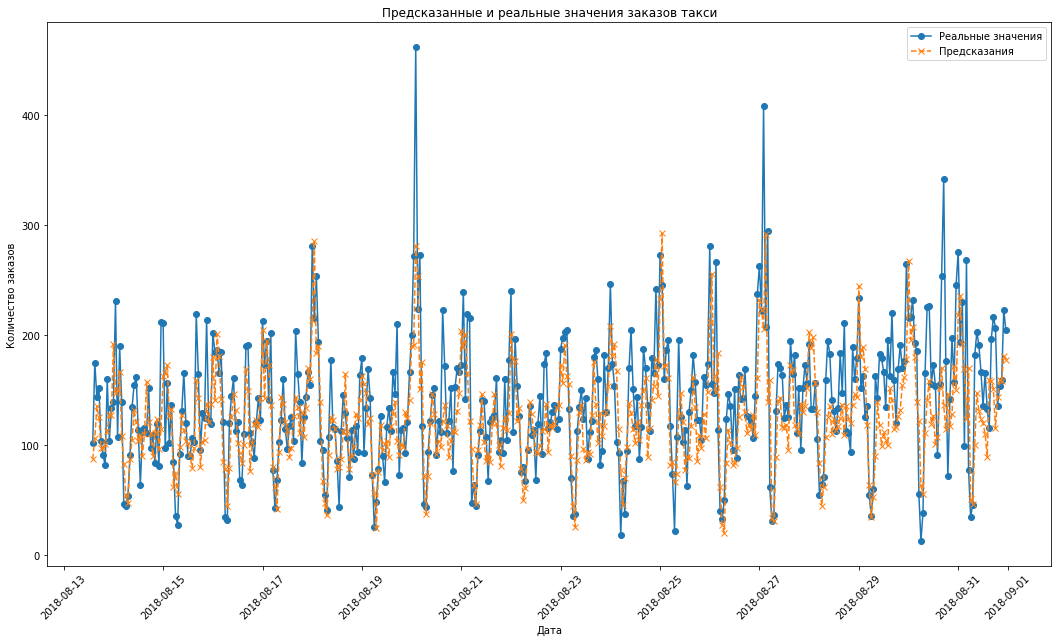

In [31]:
plt.figure(figsize=(18, 10)) 

plt.plot(target_test.index, target_test.values, label='Реальные значения', marker='o', linestyle='-')
plt.plot(target_test.index, cat_model_predict, label='Предсказания', marker='x', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Предсказанные и реальные значения заказов такси')
plt.legend()

plt.xticks(rotation=45)

plt.show()

Посмотрили график сравнения предсказанных значений и реальных. Наблюдаем что модель в целом неплохо предсказывает, но испытывает проблемы когда есть выбросы, такие как 20 августа например. В тех промежутках где таких выбросов нет, модель адекватно делает предсказания с небольшой погрешностью.

In [32]:
chart_data = [
              ["Линейная регрессия", -lr_model_cv.best_score_, "-"],
              ["Древо решений", -dt_model_cv.best_score_, "-"],
              ["Catboost", -cat_model_cv.best_score_, rmse]
]

headers = ["Модель", "RMSE на тренировочный данных", "RMSE на тестовых данных"]

chart = pd.DataFrame(chart_data, columns=headers)

display(chart)

,Модель,RMSE на тренировочный данных,RMSE на тестовых данных
0,Линейная регрессия,32.807914,-
1,Древо решений,37.012794,-
2,Catboost,28.071316,42.809889


<a id='adequacy_check'></a>
### Проверка на адекватность

Посмотрим какой результат покажет "глупая" модель, предсказывающая всегда среднее значение.

In [33]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)

dummy_train_predict = dummy.predict(features_train)
dummy_test_predict = dummy.predict(features_test)

print('RMSE на тренировочной выборке:', np.sqrt(mean_squared_error(target_train, dummy_train_predict)))
print('RMSE на тестовой выборке:', np.sqrt(mean_squared_error(target_test, dummy_test_predict)))

RMSE на тренировочной выборке: 38.67940345477774
RMSE на тестовой выборке: 84.63336276399527


Получили **RMSE = 84.63** на тестовой выборке, в два раза хуже чем Catboost. Можем сделать вывод что catboost хорошо справляется с задачей.

<a id='conclusion'></a>
## Выводы

Нам нужно было создать модель которая сможет спрогнозировать количество заказов такси из аэропорта на следующий час, для более эфективного привлечения водителей. Нам предоставили данные о заказах из аэропорта за период Март-Август 2018 года. Изучив данные мы выяснили что временной ряд не стационарный, присутсвует сезонность в виде увеличения заказов ближе 00:00 и падение около 06:00. Так же узнали что в понедельник саммая большая загруженость, а в воскресенье наоборот наименьшая.

Из предоставленных данных создали признаки необходимые для моделей машиного обучения. Обучили три модели: Линейная регрессия, Древо решений и Catboost. Использовали GridSearchCV для подбора гиперпараметров. На тренировочных данных все модели показали хорошие результаты. Мы остановились на лучшей - Catboost. Проверили её на тестовых данных и получили результат **RMSE=42.81**.

Нам удалось создать модель которая может предсказать изменение нагруски такси на час вперед с помощью имеющихся данных.